In [3]:
import torch
root_dir = "/mnt/code/users/xuziyang/PromptBias"
preds_1376_path = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt/manual_prompt/bert-base-cased/LAMA/debias_answer_type_tokens/origin_embedding/preds.pt"
preds_1376 = torch.load(preds_1376_path)
preds_1376["WIKI-UNI"].keys()

dict_keys(['P19', 'P20', 'P279', 'P37', 'P413', 'P449', 'P47', 'P138', 'P364', 'P463', 'P101', 'P106', 'P527', 'P530', 'P176', 'P27', 'P407', 'P30', 'P178', 'P1376', 'P131', 'P1412', 'P108', 'P136', 'P17', 'P39', 'P264', 'P276', 'P937', 'P140', 'P1303', 'P127', 'P103', 'P190', 'P1001', 'P31', 'P495', 'P159', 'P36', 'P740', 'P361'])

In [5]:
import os
import torch
preds_1376_path = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt/manual_prompt/bert-base-cased/LAMA/debias_answer_type_tokens/origin_embedding/preds.pt"
preds_1376 = torch.load(preds_1376_path)
UNI_1376 = preds_1376["WIKI-UNI"]["P1376"]["data"]

import pandas as pd
df = pd.DataFrame(UNI_1376)

# 获取bias subset indices
bias_subset_indices = torch.load("/mnt/code/users/xuziyang/PromptBias/code/analysis/P1376_subvocab.pt")
bias_logits = torch.load("/mnt/code/users/xuziyang/PromptBias/code/analysis/P1376_bias_logits.pt")

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokens = tokenizer.convert_ids_to_tokens(bias_subset_indices.tolist())
logits = bias_logits[bias_subset_indices].tolist()

info = list(sorted(zip(logits,bias_subset_indices,tokens), reverse=True))
with open("/mnt/code/users/xuziyang/PromptBias/code/analysis/P1376_info.txt","w") as f:
    [f.write(str(i)+"\n") for i in info]


In [6]:
import os
import torch
preds_1412_path = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt/manual_prompt/bert-base-cased/LAMA/debias_answer_type_tokens/origin_embedding/preds.pt"
preds_1412 = torch.load(preds_1412_path)
UNI_1412 = preds_1412["WIKI-UNI"]["P1412"]["data"]

import pandas as pd
df = pd.DataFrame(UNI_1412)

# 获取bias subset indices
bias_subset_indices = torch.load("/mnt/code/users/xuziyang/PromptBias/code/analysis/P1412_subvocab.pt")
bias_logits = torch.load("/mnt/code/users/xuziyang/PromptBias/code/analysis/P1412_bias_logits.pt")

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokens = tokenizer.convert_ids_to_tokens(bias_subset_indices.tolist())
logits = bias_logits[bias_subset_indices].tolist()

info = list(sorted(zip(logits,bias_subset_indices,tokens), reverse=True))
with open("/mnt/code/users/xuziyang/PromptBias/code/analysis/P1412_info.txt","w") as f:
    [f.write(str(i)+"\n") for i in info]


,index,sub_label,obj_labels,raw_preds,debiased_preds
25,25,Britta Rådström,Swedish,English,Swedish
26,26,Inga-Britt Johansson,Swedish,English,Norwegian
27,27,Irving Bernstein,Swedish,English,Yiddish
28,28,Staffan Appelros,Swedish,English,Thai
29,29,Gunnel Granlid,Swedish,Norwegian,Norwegian
...,...,...,...,...,...
1145,1145,Satyabhushan Banerjea,Bengali,Sanskrit,Marathi
1146,1146,Hara Kumar Tagore,Bengali,Hindi,Bengali
1147,1147,Abdullah-Al-Muti,Bengali,Arabic,Arabic
1148,1148,Navana Akter,Bengali,English,Tamil


In [7]:
sorted_logits_tokens = list(sorted(zip(logits,tokens),reverse=True))
sorted_logits, sorted_tokens = zip(*sorted_logits_tokens)

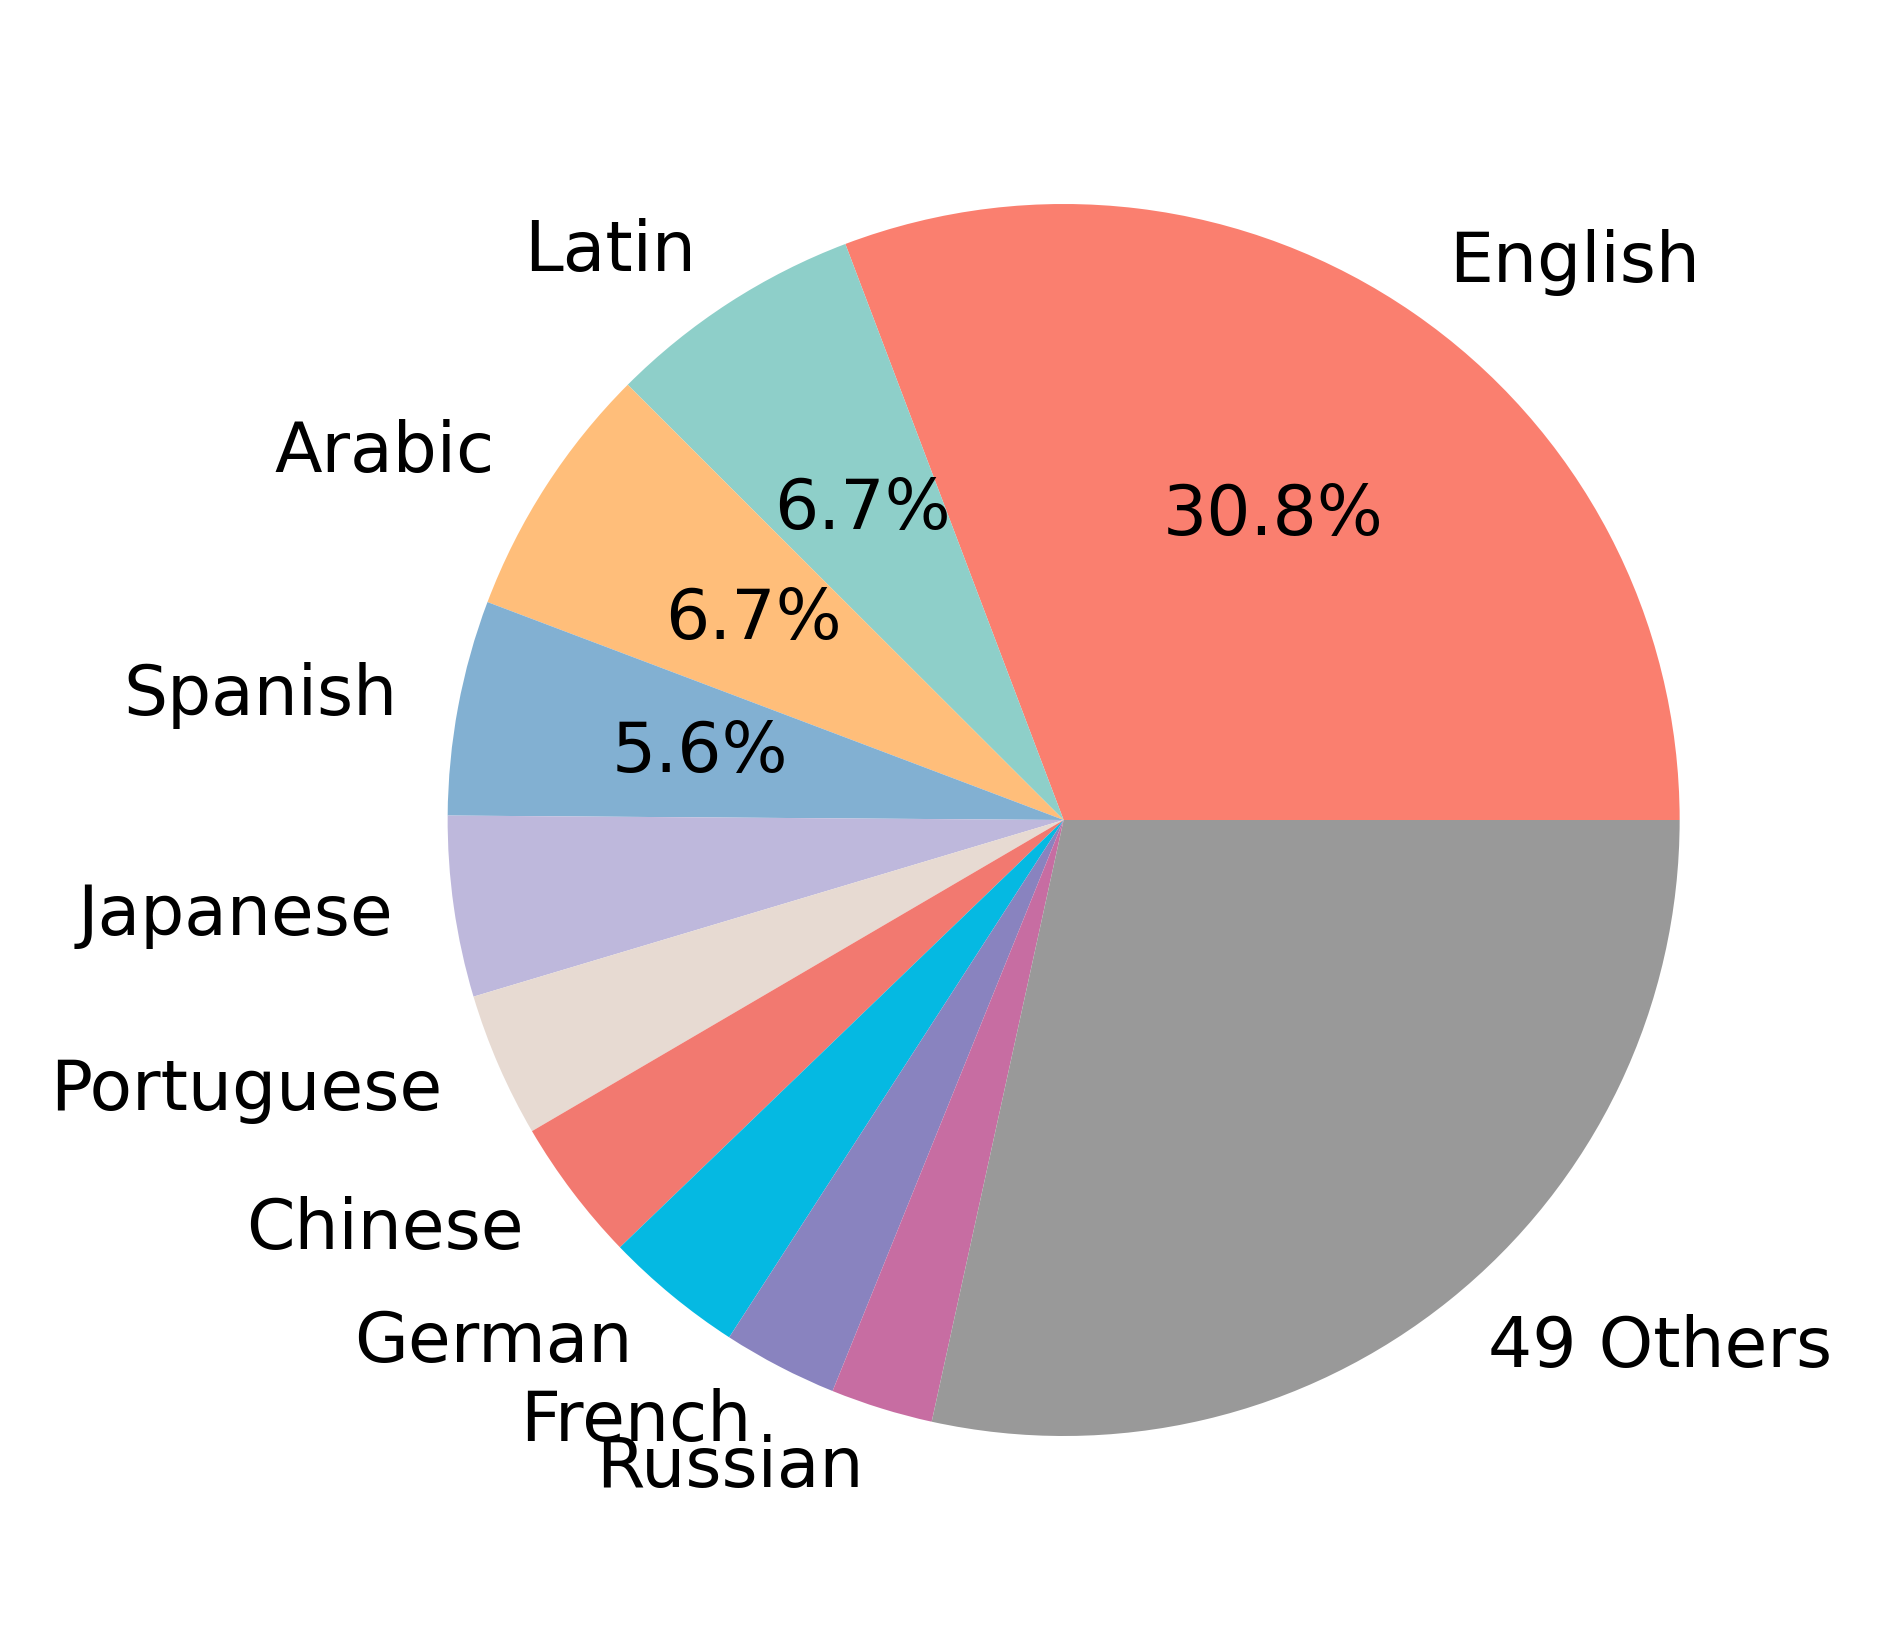

<Figure size 640x480 with 0 Axes>

In [9]:
import math
# 画bias logits饼图
# 对prompt bias计算得到的概率值画个饼图
sorted_logits_tokens = list(sorted(zip(logits,tokens),reverse=True))
sorted_logits, sorted_tokens = zip(*sorted_logits_tokens)
bias_tokens = sorted_tokens
sorted_tokens = list(sorted_tokens)
# 计算得到概率值，并且将最后的元素加起来，得到一个others
probs = torch.softmax(torch.tensor(sorted_logits),dim=0).tolist()
from copy import copy
old_probs = copy(probs)
probs = old_probs[:10]
probs.append(sum(old_probs[10:]))


from matplotlib import pyplot as plt
colors = ["#FA7F6F", "#8ECFC9","#FFBE7A","#82B0D2","#BEB8DC","#E7DAD2",
"#F27970",
"#05B9E2",
"#8983BF",
"#C76DA2",] + ["#999999"] * 30
labels=sorted_tokens[:10] + ["49 Others"]
length = len(probs)
labels = labels + [""] * (length-len(labels))
plt.figure(figsize=(4, 4), dpi=500)
plt.pie(probs,colors=colors,labels=labels,
autopct=lambda pct: f"{pct:.1f}%" if pct > 5 and not abs(pct-probs[-1]*100)<1  else '')
# textprops={'fontsize': 8},)

plt.savefig("template_bias.pdf",transparent=True, bbox_inches='tight')
plt.show()
plt.clf()

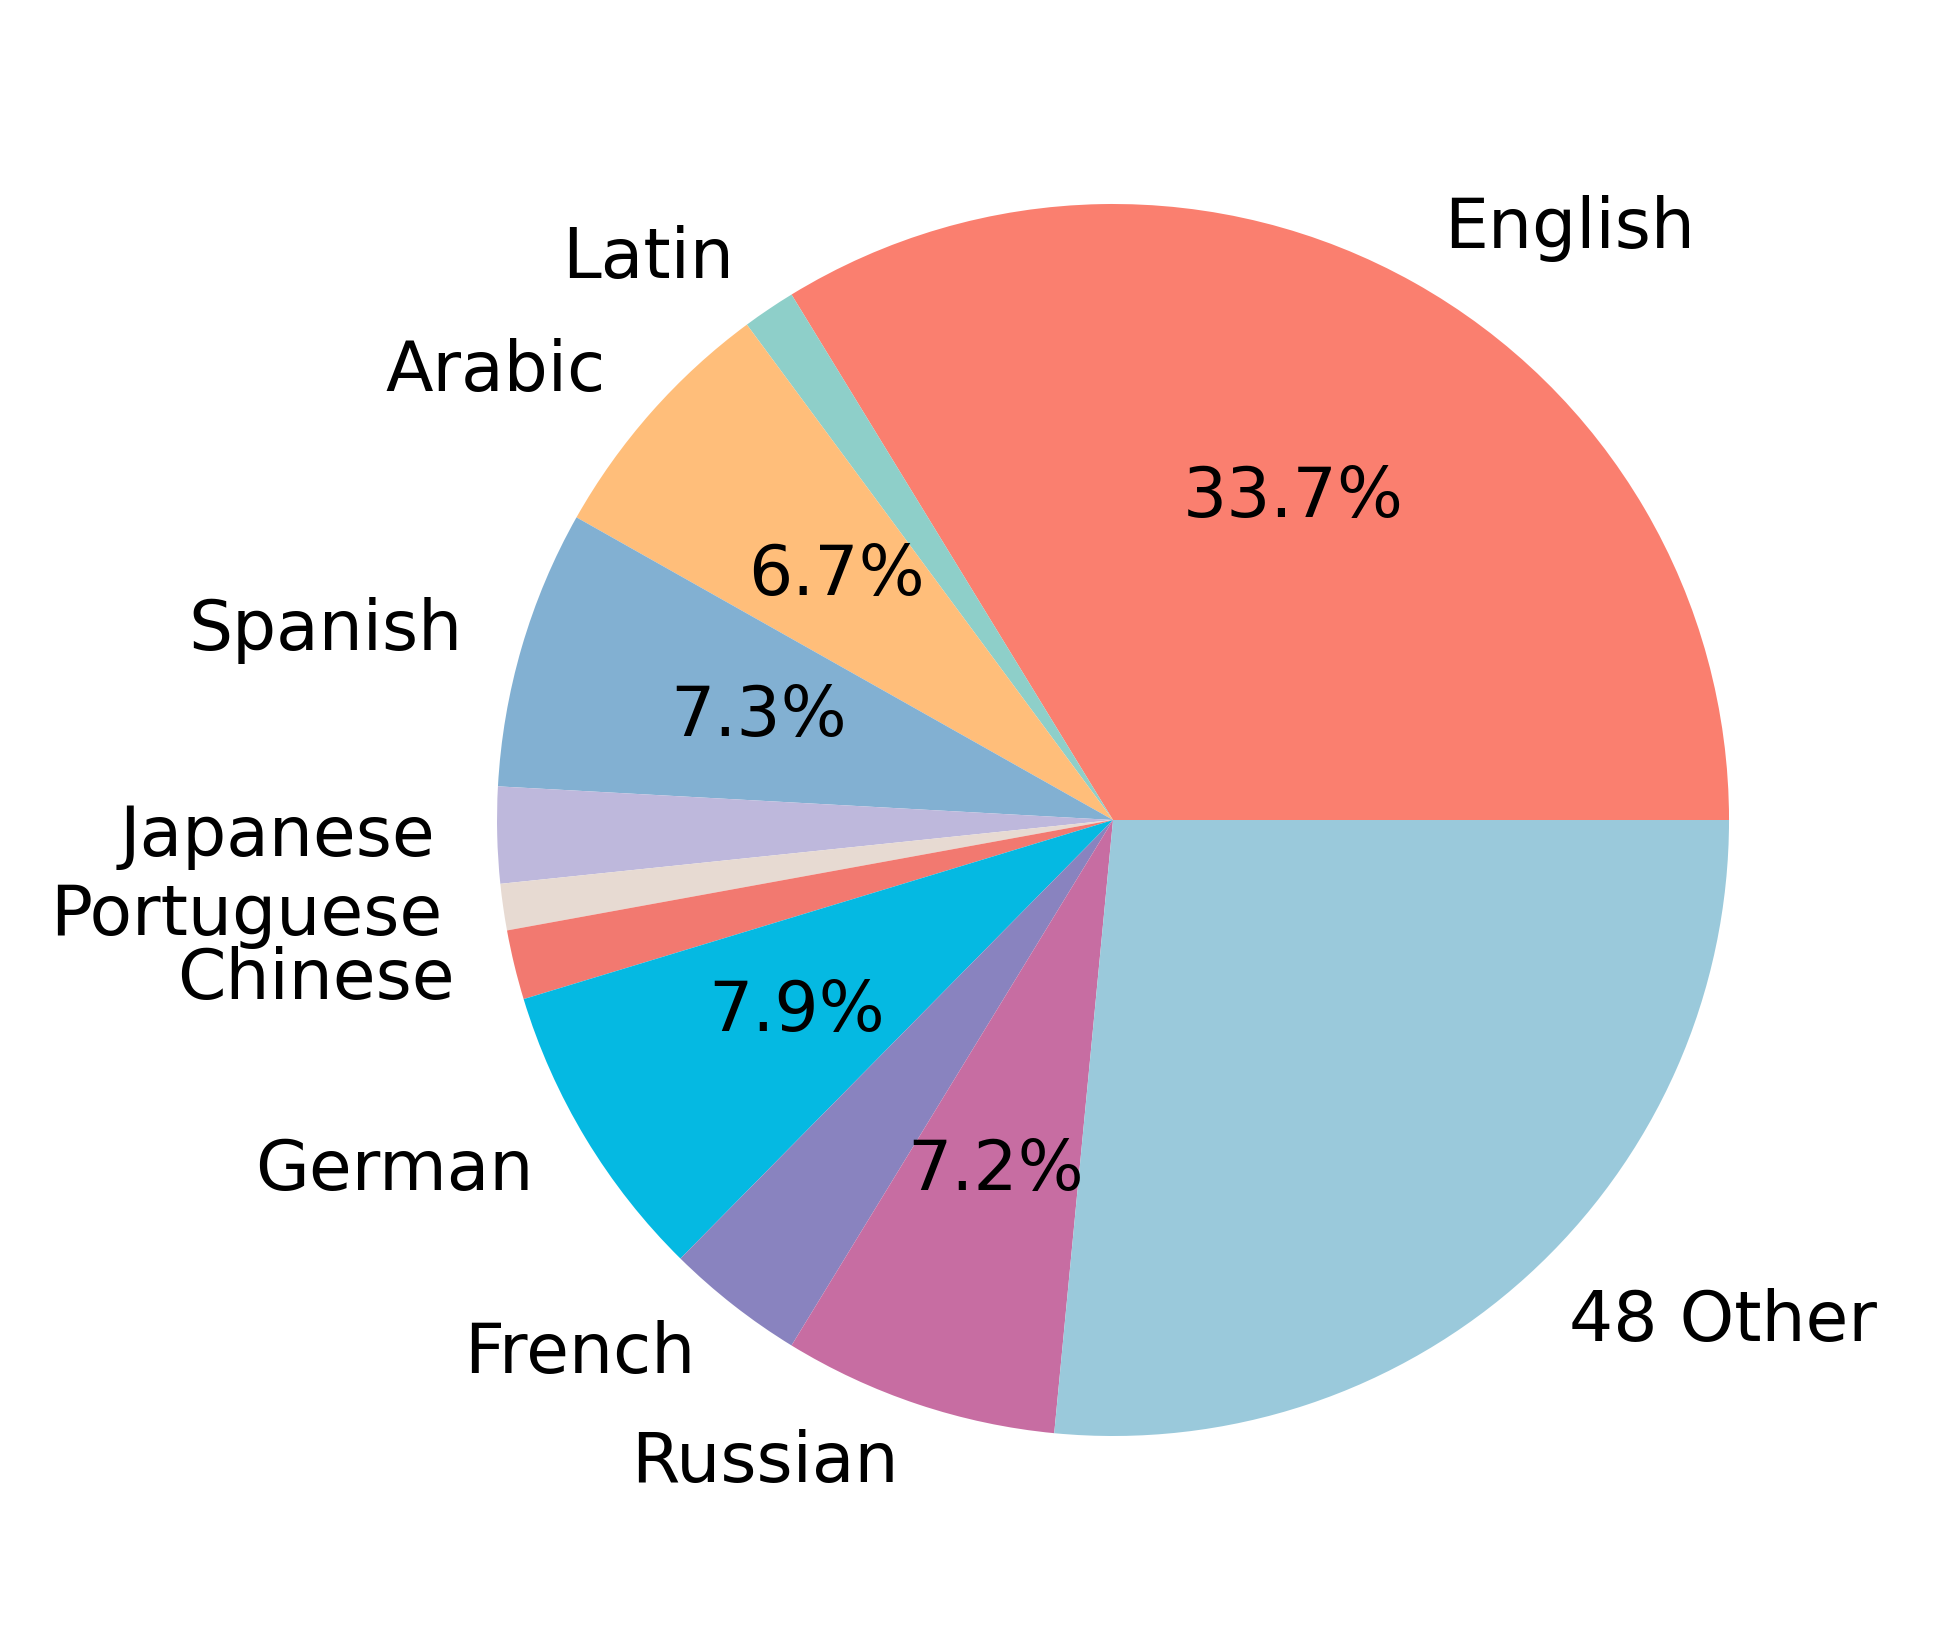

In [19]:
import numpy as np
# 画出来predictions的饼图
sorted_series = df['raw_preds'].value_counts().sort_values(ascending=False)
sorted_num = list(sorted_series)
sorted_probs = np.array(sorted_num)/ sum(sorted_num)
sorted_tokens = sorted_series.index
sorted_tokens = list(sorted_tokens)

show_num = 10

new_probs_tokens = []
# 对probs和tokens的顺序调整一下,保持和bias一样
for token in bias_tokens:
    try:
        idx = sorted_tokens.index(token)
        prob = sorted_probs[idx]
    except:
        prob = 0
    new_probs_tokens.append((prob,token))

sorted_probs, sorted_tokens = zip(*new_probs_tokens)
sorted_probs = list(sorted_probs)
sorted_tokens = list(sorted_tokens)

probs = sorted_probs
# 计算得到概率值，并且将最后的元素加起来，得到一个others
# probs = torch.softmax(torch.tensor(sorted_logits),dim=0).tolist()
from copy import copy
old_probs = copy(probs)
probs = old_probs[:show_num]
probs.append(sum(old_probs[show_num:]))


from matplotlib import pyplot as plt
colors = ["#FA7F6F", "#8ECFC9","#FFBE7A","#82B0D2","#BEB8DC","#E7DAD2",
"#F27970",
"#05B9E2",
"#8983BF",
"#C76DA2",
"#9ac9db"] 

labels=sorted_tokens[:show_num]  + [  str(len(sorted_probs)-show_num) + " Other"]
length = len(probs)
labels = labels + [""] * (length-len(labels))
plt.figure(figsize=(4, 4), dpi=500)
plt.pie(probs,colors=colors,labels=labels,
autopct=lambda pct: f"{pct:.1f}%" if pct > 5 and not abs(pct-probs[-1]*100)<1  else '')
# textprops={'fontsize': 8},)

# probs = sorted_probs
# from matplotlib import pyplot as plt
# colors = ["#FA7F6F", "#8ECFC9","#FFBE7A","#82B0D2","#BEB8DC","#E7DAD2",
# "#F27970",
# "#05B9E2",
# "#8983BF",
# "#C76DA2",] + ["#999999"] * 50
# labels=sorted_tokens[:10] + [""] * 5 + ["48 Others"]
# length = len(probs)
# labels = labels + [""] * (length-len(labels))
# plt.figure(figsize=(6, 6), dpi=500)
# plt.pie(probs,colors=colors,labels=labels,
# # textprops={'fontsize': 8},
# autopct=lambda pct: f"{pct:.1f}%" if pct > 3.2 else '')

plt.savefig("predictions.pdf",transparent=True, bbox_inches='tight')
plt.show()

In [102]:
df['raw_preds'].value_counts().sort_values(ascending=False)

raw_preds
English       388
German         91
Spanish        84
Russian        83
Arabic         77
French         42
Sanskrit       36
Italian        32
Greek          30
Japanese       29
Hungarian      25
Polish         23
Chinese        21
Icelandic      21
Hebrew         18
Korean         17
Latin          16
Turkish        16
Portuguese     14
Finnish        10
Persian        10
Welsh           9
Norwegian       9
Dutch           8
Catalan         8
Czech           8
Romanian        7
Lithuanian      5
Swedish         4
Telugu          3
Urdu            3
Tamil           1
Bulgarian       1
Hindi           1
Name: count, dtype: int64

In [38]:
df["debiased_preds"].value_counts().sort_values(ascending=False)

debiased_preds
Spanish        55
German         52
Italian        39
Japanese       38
Russian        38
French         36
Welsh          33
Icelandic      32
Norwegian      32
Greek          31
Polish         30
Tamil          30
Chinese        29
Croatian       27
Lithuanian     26
Dutch          24
Arabic         24
Slovak         24
Korean         23
Persian        23
Ukrainian      22
Serbian        22
Hebrew         22
Urdu           22
Hungarian      21
Telugu         21
Punjabi        21
Danish         21
Egyptian       20
Turkish        19
Latvian        19
Portuguese     19
Georgian       19
Romanian       19
Catalan        18
Czech          17
Finnish        16
Irish          14
Basque         14
Yiddish        12
Azerbaijani    12
Hindi          11
Breton         11
Thai           11
Sanskrit       11
Swedish        10
Bengali        10
Armenian        9
Estonian        9
Bulgarian       7
Marathi         6
Indonesian      6
Slovene         5
Maltese         3
Malayalam    

In [40]:
# 选出来raw_preds是英语，obj_labels不是英语,且debiased_preds==obj_labels的row
selected_rows = df[(df['raw_preds'] == 'English') & (df['obj_labels'] != 'English') & (df['debiased_preds'] == df['obj_labels'])]
selected_rows

,index,sub_label,obj_labels,raw_preds,debiased_preds
5,5,Christian Streffer,German,English,German
21,21,Stephan Tromp,German,English,German
25,25,Britta Rådström,Swedish,English,Swedish
33,33,Karl Alvar Nilsson,Swedish,English,Swedish
38,38,Per Olof Ekström,Swedish,English,Swedish
...,...,...,...,...,...
1114,1114,Gunnar Birgisson,Icelandic,English,Icelandic
1133,1133,Suresh Chandra Chattopadhyay,Bengali,English,Bengali
1138,1138,Sunil Gangopadhyay,Bengali,English,Bengali
1139,1139,Kshriod Chandra Roy Chowdhury,Bengali,English,Bengali


In [41]:
# 选出来raw_preds是英语，obj_labels不是英语,且debiased_preds==obj_labels的row
selected_rows = df[(df['raw_preds'] == 'English') & (df['obj_labels'] != 'English') & (df['debiased_preds'] != df['obj_labels'])]
selected_rows

,index,sub_label,obj_labels,raw_preds,debiased_preds
9,9,Rosemarie Schuder,German,English,Yiddish
14,14,Tyyne Claudia Pollmann,German,English,Romanian
18,18,Nicole Ansari,German,English,Arabic
19,19,Dankward Buwitt,German,English,Dutch
22,22,Richard Tarnas,German,English,Welsh
...,...,...,...,...,...
1116,1116,Steinar Bragi,Icelandic,English,Norwegian
1129,1129,Satyen Sen,Bengali,English,Punjabi
1135,1135,Sukumar Barua,Bengali,English,Hindi
1148,1148,Navana Akter,Bengali,English,Tamil
